# IMPORTING LIBRARIES

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# IMPORTING DATASET

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,26-01-2021 02:21,556753,26-01-2021 00:00,26-01-2021 02:21,26-01-2021 02:22,26-01-2021 02:32,26-01-2021 02:49,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,26-01-2021 02:33,556754,26-01-2021 00:00,26-01-2021 02:33,26-01-2021 02:34,26-01-2021 02:50,26-01-2021 03:11,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN
2,26-01-2021 02:39,556755,26-01-2021 00:00,26-01-2021 02:39,26-01-2021 02:40,26-01-2021 02:56,26-01-2021 03:12,18623,2.2074,4.80,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.816667,NaN
3,26-01-2021 02:47,556756,26-01-2021 00:00,26-01-2021 02:48,26-01-2021 02:49,26-01-2021 03:21,26-01-2021 03:41,15945,2.1894,6.38,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.533333,NaN
4,26-01-2021 03:06,556757,26-01-2021 00:00,26-01-2021 03:07,26-01-2021 03:07,26-01-2021 03:31,26-01-2021 04:00,17589,2.7870,4.01,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.350000,NaN


# FEATURE ENGINEERING

In [5]:
train_=train.groupby(['rider_id']).apply(lambda x: x.sort_values(['order_time'], ascending = True)).reset_index(drop=True)
test_=test.groupby(['rider_id']).apply(lambda x: x.sort_values(['order_time'], ascending = True)).reset_index(drop=True)

In [6]:
train_['session_time'].fillna(train_['session_time'].mean(),inplace=True)
test_['session_time'].fillna(test_['session_time'].mean(),inplace=True)

In [7]:
train_['total_distance']=train_['first_mile_distance']+train_['last_mile_distance']
test_['total_distance']=test_['first_mile_distance']+test_['last_mile_distance']

In [8]:
train_['session_time_diff']=train_.session_time.apply(lambda x: x[i+1]-x[i] if(x[i+1]>x[i]) else x[i] for i in range(0,len(train_)-1)).reset_index(drop=True)
test_['session_time_diff']=test_.session_time.apply(lambda x: x[i+1]-x[i] if(x[i+1]>x[i]) else x[i] for i in range(0,len(test_)-1)).reset_index(drop=True)

In [9]:
train_['session_time_diff'].fillna(train_['session_time'][len(train_)-1],inplace=True)
train_['reassigned_order'].fillna(0,inplace=True)
test_['session_time_diff'].fillna(test_['session_time'][len(test_)-1],inplace=True)
test_['reassigned_order'].fillna(0,inplace=True)

In [22]:
train_['feat_1']=pd.to_datetime(train_['order_time']).dt.hour*60+pd.to_datetime(train_['order_time']).dt.minute
test_['feat_1']=pd.to_datetime(test_['order_time']).dt.hour*60+pd.to_datetime(test_['order_time']).dt.minute

In [27]:
train_['feat_2']=pd.to_datetime(train_['allot_time']).dt.hour*60+pd.to_datetime(train_['allot_time']).dt.minute
test_['feat_2']=pd.to_datetime(test_['allot_time']).dt.hour*60+pd.to_datetime(test_['allot_time']).dt.minute

In [28]:
train_['feat_3']=pd.to_datetime(train_['accept_time']).dt.hour*60+pd.to_datetime(train_['accept_time']).dt.minute
test_['feat_3']=pd.to_datetime(test_['accept_time']).dt.hour*60+pd.to_datetime(test_['accept_time']).dt.minute

In [29]:
train_['feat_3'].fillna(train_['feat_3'].mean(),inplace=True)
test_['feat_3'].fillna(test_['feat_3'].mean(),inplace=True)

In [31]:
train_['feat_4']=train_['feat_2']-train_['feat_1']
test_['feat_4']=test_['feat_2']-test_['feat_1']

In [32]:
train_['feat_5']=train_['feat_3']-train_['feat_2']
test_['feat_5']=test_['feat_3']-test_['feat_2']

In [35]:
train_['allot_time_diff']=train_.feat_2.apply(lambda x: x[i+1]-x[i] if(x[i+1]>x[i]) else 0 for i in range(0,len(train_)-1)).reset_index(drop=True)
test_['allot_time_diff']=test_.feat_2.apply(lambda x: x[i+1]-x[i] if(x[i+1]>x[i]) else 0 for i in range(0,len(test_)-1)).reset_index(drop=True)

In [36]:
train_['allot_time_diff'].fillna(train_['allot_time_diff'].mean(),inplace=True)
test_['allot_time_diff'].fillna(test_['allot_time_diff'].mean(),inplace=True)

In [38]:
train_['lifetime_order_count'].fillna(train_['lifetime_order_count'].median(),inplace=True)
test_['lifetime_order_count'].fillna(test_['lifetime_order_count'].median(),inplace=True)

In [39]:
train_['delivered_orders'].fillna(train_['delivered_orders'].median(),inplace=True)
test_['delivered_orders'].fillna(test_['delivered_orders'].median(),inplace=True)

In [40]:
train_['alloted_orders'].fillna(train_['alloted_orders'].median(),inplace=True)
test_['alloted_orders'].fillna(test_['alloted_orders'].median(),inplace=True)

In [41]:
train_['undelivered_orders'].fillna(train_['undelivered_orders'].median(),inplace=True)
test_['undelivered_orders'].fillna(test_['undelivered_orders'].median(),inplace=True)

In [43]:
train_['feat_6']=(train_['delivered_orders']+1)/(train_['alloted_orders']+1)
test_['feat_6']=(test_['delivered_orders']+1)/(test_['alloted_orders']+1)

In [50]:
train_['feat_7']=(train_['session_time_diff']+1)/(train_['session_time']+1)
test_['feat_7']=(test_['session_time_diff']+1)/(test_['session_time']+1)

In [51]:
df_train=train_[['first_mile_distance','last_mile_distance','total_distance','session_time_diff','reassigned_order','feat_4','feat_5','allot_time_diff','lifetime_order_count','feat_6','feat_7','cancelled']]
df_test=test_[['first_mile_distance','last_mile_distance','total_distance','session_time_diff','reassigned_order','feat_4','feat_5','allot_time_diff','lifetime_order_count','feat_6','feat_7']]

# TRAIN-TEST SPLIT

In [53]:
train_X = df_train.drop('cancelled',axis=1)
train_Y = df_train['cancelled']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(train_X,train_Y,test_size=0.2,random_state=7,stratify=np.array(train_Y))

In [55]:
eval_set=[(X_test, y_test)]

# HYPERPARAMETER TUNING

In [56]:
xgbc_1=xgb.XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=85,seed=27)
xgbc_1.fit(X_train,y_train,eval_metric='auc',eval_set=eval_set,early_stopping_rounds=100,verbose=True)
predictions = xgbc_1.predict(X_test)
accuracy_score(y_test,predictions)

[0]	validation_0-auc:0.72187
[1]	validation_0-auc:0.73065
[2]	validation_0-auc:0.73597
[3]	validation_0-auc:0.74104
[4]	validation_0-auc:0.74631
[5]	validation_0-auc:0.75060
[6]	validation_0-auc:0.75562
[7]	validation_0-auc:0.75759
[8]	validation_0-auc:0.75949
[9]	validation_0-auc:0.75989
[10]	validation_0-auc:0.76082
[11]	validation_0-auc:0.76143
[12]	validation_0-auc:0.76320
[13]	validation_0-auc:0.76412
[14]	validation_0-auc:0.76492
[15]	validation_0-auc:0.76606
[16]	validation_0-auc:0.76730
[17]	validation_0-auc:0.76749
[18]	validation_0-auc:0.76790
[19]	validation_0-auc:0.76861
[20]	validation_0-auc:0.76779
[21]	validation_0-auc:0.76968
[22]	validation_0-auc:0.77080
[23]	validation_0-auc:0.77138
[24]	validation_0-auc:0.77229
[25]	validation_0-auc:0.77361
[26]	validation_0-auc:0.77426
[27]	validation_0-auc:0.77486
[28]	validation_0-auc:0.77525
[29]	validation_0-auc:0.77446
[30]	validation_0-auc:0.77485
[31]	validation_0-auc:0.77578
[32]	validation_0-auc:0.77616
[33]	validation_0-au

0.8239

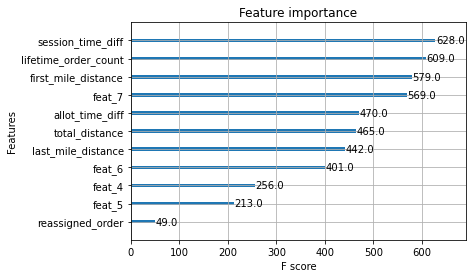

In [57]:
plot_importance(xgbc_1)
plt.show()

In [58]:
xgbc_2=xgb.XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=85,seed=27)
param_test2 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch2 = GridSearchCV(estimator=xgbc_2,param_grid=param_test2,scoring='roc_auc',n_jobs=-1,cv=5)
gsearch2.fit(X_train,y_train,eval_metric='auc')
gsearch2.best_params_

{'max_depth': 3, 'min_child_weight': 5}

In [59]:
gsearch2.best_score_

0.7856054794618702

In [60]:
xgbc_3=xgb.XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=3,min_child_weight=5,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=85,seed=27)
param_test3 = {
 'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}
gsearch3 = GridSearchCV(estimator=xgbc_3,param_grid=param_test3,scoring='roc_auc',n_jobs=4,cv=5)
gsearch3.fit(X_train,y_train,eval_metric='auc')
gsearch3.best_params_

{'max_depth': 4, 'min_child_weight': 4}

In [61]:
gsearch3.best_score_

0.7863177835805872

In [62]:
xgbc_4=xgb.XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=4,min_child_weight=4,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=85,seed=27)
param_test4 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch4=GridSearchCV(estimator=xgbc_4,param_grid=param_test4,scoring='roc_auc',n_jobs=4,cv=5)
gsearch4.fit(X_train,y_train,eval_metric='auc')
gsearch4.best_params_

{'gamma': 0.4}

In [63]:
gsearch4.best_score_

0.7867293631754303

In [65]:
xgbc_5=xgb.XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=4,min_child_weight=4,gamma=0.4,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=85,seed=27)
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5=GridSearchCV(estimator=xgbc_5,param_grid=param_test5,scoring='roc_auc',n_jobs=4,cv=5)
gsearch5.fit(X_train,y_train,eval_metric='auc')
gsearch5.best_params_

{'colsample_bytree': 0.6, 'subsample': 0.9}

In [66]:
gsearch5.best_score_

0.7870714209917068

In [72]:
xgbc_6=xgb.XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=4,min_child_weight=4,gamma=0.4,subsample=0.9,colsample_bytree=0.6,objective='binary:logistic',nthread=4,scale_pos_weight=85,seed=27)
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator=xgbc_6,param_grid=param_test6,scoring='roc_auc',n_jobs=4,cv=5)
gsearch6.fit(X_train,y_train,eval_metric='auc')
gsearch6.best_params_

{'reg_alpha': 100}

In [73]:
gsearch6.best_score_

0.7880096372380387

In [75]:
xgbc_7=xgb.XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=4,min_child_weight=4,gamma=0.4,subsample=0.9,colsample_bytree=0.6,objective='binary:logistic',nthread=4,scale_pos_weight=85,seed=27)
param_test7 = {
 'reg_alpha':[95,96,97,98,99,100]
}
gsearch7 = GridSearchCV(estimator=xgbc_7,param_grid=param_test7,scoring='roc_auc',n_jobs=4,cv=5)
gsearch7.fit(X_train,y_train,eval_metric='auc')
gsearch7.best_params_

{'reg_alpha': 100}

In [76]:
gsearch7.best_score_

0.7880096372380387

In [77]:
xgbc_9=xgb.XGBClassifier(learning_rate =0.01,n_estimators=5000,max_depth=4,min_child_weight=4,gamma=0.4,subsample=0.9,colsample_bytree=0.6,reg_alpha=100,objective='binary:logistic',nthread=4,scale_pos_weight=85,seed=27)
xgbc_9.fit(X_train,y_train,eval_metric='auc',eval_set=eval_set,early_stopping_rounds=100,verbose=True)
predictions=xgbc_9.predict_proba(X_test)
roc_auc_score(y_test,predictions[:,1])

[0]	validation_0-auc:0.70707
[1]	validation_0-auc:0.72842
[2]	validation_0-auc:0.72689
[3]	validation_0-auc:0.73279
[4]	validation_0-auc:0.74375
[5]	validation_0-auc:0.74551
[6]	validation_0-auc:0.74327
[7]	validation_0-auc:0.74891
[8]	validation_0-auc:0.75185
[9]	validation_0-auc:0.75197
[10]	validation_0-auc:0.75505
[11]	validation_0-auc:0.75367
[12]	validation_0-auc:0.75512
[13]	validation_0-auc:0.75569
[14]	validation_0-auc:0.75516
[15]	validation_0-auc:0.75563
[16]	validation_0-auc:0.75609
[17]	validation_0-auc:0.75625
[18]	validation_0-auc:0.75682
[19]	validation_0-auc:0.75757
[20]	validation_0-auc:0.75833
[21]	validation_0-auc:0.75859
[22]	validation_0-auc:0.75859
[23]	validation_0-auc:0.75861
[24]	validation_0-auc:0.75997
[25]	validation_0-auc:0.75992
[26]	validation_0-auc:0.76046
[27]	validation_0-auc:0.76055
[28]	validation_0-auc:0.76092
[29]	validation_0-auc:0.76060
[30]	validation_0-auc:0.76136
[31]	validation_0-auc:0.76101
[32]	validation_0-auc:0.76046
[33]	validation_0-au

[268]	validation_0-auc:0.77471
[269]	validation_0-auc:0.77475
[270]	validation_0-auc:0.77474
[271]	validation_0-auc:0.77481
[272]	validation_0-auc:0.77486
[273]	validation_0-auc:0.77489
[274]	validation_0-auc:0.77492
[275]	validation_0-auc:0.77496
[276]	validation_0-auc:0.77502
[277]	validation_0-auc:0.77507
[278]	validation_0-auc:0.77510
[279]	validation_0-auc:0.77516
[280]	validation_0-auc:0.77525
[281]	validation_0-auc:0.77528
[282]	validation_0-auc:0.77530
[283]	validation_0-auc:0.77531
[284]	validation_0-auc:0.77531
[285]	validation_0-auc:0.77538
[286]	validation_0-auc:0.77543
[287]	validation_0-auc:0.77549
[288]	validation_0-auc:0.77551
[289]	validation_0-auc:0.77556
[290]	validation_0-auc:0.77570
[291]	validation_0-auc:0.77575
[292]	validation_0-auc:0.77576
[293]	validation_0-auc:0.77580
[294]	validation_0-auc:0.77584
[295]	validation_0-auc:0.77585
[296]	validation_0-auc:0.77589
[297]	validation_0-auc:0.77590
[298]	validation_0-auc:0.77595
[299]	validation_0-auc:0.77601
[300]	va

[533]	validation_0-auc:0.78287
[534]	validation_0-auc:0.78289
[535]	validation_0-auc:0.78287
[536]	validation_0-auc:0.78289
[537]	validation_0-auc:0.78293
[538]	validation_0-auc:0.78297
[539]	validation_0-auc:0.78303
[540]	validation_0-auc:0.78303
[541]	validation_0-auc:0.78311
[542]	validation_0-auc:0.78314
[543]	validation_0-auc:0.78315
[544]	validation_0-auc:0.78320
[545]	validation_0-auc:0.78320
[546]	validation_0-auc:0.78325
[547]	validation_0-auc:0.78325
[548]	validation_0-auc:0.78325
[549]	validation_0-auc:0.78326
[550]	validation_0-auc:0.78328
[551]	validation_0-auc:0.78328
[552]	validation_0-auc:0.78328
[553]	validation_0-auc:0.78332
[554]	validation_0-auc:0.78334
[555]	validation_0-auc:0.78335
[556]	validation_0-auc:0.78335
[557]	validation_0-auc:0.78341
[558]	validation_0-auc:0.78341
[559]	validation_0-auc:0.78341
[560]	validation_0-auc:0.78344
[561]	validation_0-auc:0.78345
[562]	validation_0-auc:0.78344
[563]	validation_0-auc:0.78343
[564]	validation_0-auc:0.78343
[565]	va

[798]	validation_0-auc:0.78709
[799]	validation_0-auc:0.78712
[800]	validation_0-auc:0.78712
[801]	validation_0-auc:0.78714
[802]	validation_0-auc:0.78714
[803]	validation_0-auc:0.78713
[804]	validation_0-auc:0.78715
[805]	validation_0-auc:0.78716
[806]	validation_0-auc:0.78714
[807]	validation_0-auc:0.78715
[808]	validation_0-auc:0.78716
[809]	validation_0-auc:0.78716
[810]	validation_0-auc:0.78718
[811]	validation_0-auc:0.78719
[812]	validation_0-auc:0.78719
[813]	validation_0-auc:0.78719
[814]	validation_0-auc:0.78715
[815]	validation_0-auc:0.78716
[816]	validation_0-auc:0.78718
[817]	validation_0-auc:0.78718
[818]	validation_0-auc:0.78718
[819]	validation_0-auc:0.78719
[820]	validation_0-auc:0.78719
[821]	validation_0-auc:0.78722
[822]	validation_0-auc:0.78726
[823]	validation_0-auc:0.78724
[824]	validation_0-auc:0.78724
[825]	validation_0-auc:0.78724
[826]	validation_0-auc:0.78724
[827]	validation_0-auc:0.78727
[828]	validation_0-auc:0.78727
[829]	validation_0-auc:0.78728
[830]	va

[1061]	validation_0-auc:0.78906
[1062]	validation_0-auc:0.78908
[1063]	validation_0-auc:0.78911
[1064]	validation_0-auc:0.78912
[1065]	validation_0-auc:0.78913
[1066]	validation_0-auc:0.78913
[1067]	validation_0-auc:0.78913
[1068]	validation_0-auc:0.78912
[1069]	validation_0-auc:0.78910
[1070]	validation_0-auc:0.78910
[1071]	validation_0-auc:0.78911
[1072]	validation_0-auc:0.78912
[1073]	validation_0-auc:0.78912
[1074]	validation_0-auc:0.78912
[1075]	validation_0-auc:0.78912
[1076]	validation_0-auc:0.78910
[1077]	validation_0-auc:0.78909
[1078]	validation_0-auc:0.78909
[1079]	validation_0-auc:0.78908
[1080]	validation_0-auc:0.78907
[1081]	validation_0-auc:0.78906
[1082]	validation_0-auc:0.78911
[1083]	validation_0-auc:0.78912
[1084]	validation_0-auc:0.78913
[1085]	validation_0-auc:0.78912
[1086]	validation_0-auc:0.78912
[1087]	validation_0-auc:0.78913
[1088]	validation_0-auc:0.78912
[1089]	validation_0-auc:0.78911
[1090]	validation_0-auc:0.78916
[1091]	validation_0-auc:0.78916
[1092]	v

0.7894581724418754

# FINAL PREDICTION

In [78]:
xgbc_10=xgb.XGBClassifier(learning_rate =0.01,n_estimators=1200,max_depth=4,min_child_weight=4,gamma=0.4,subsample=0.9,colsample_bytree=0.6,reg_alpha=100,objective='binary:logistic',nthread=4,scale_pos_weight=85,seed=27)
xgbc_10.fit(train_X,train_Y,eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0.4, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=27, reg_alpha=100, reg_lambda=1,
              scale_pos_weight=85, seed=27, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [79]:
predict=xgbc_10.predict_proba(train_X)
roc_auc_score(train_Y,predict[:,1])

0.8146118218690099

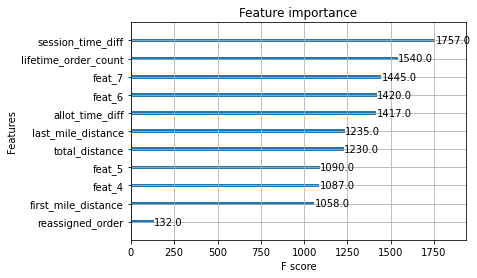

In [80]:
plot_importance(xgbc_10)
plt.show()

In [81]:
predictions=xgbc_10.predict(df_test)

In [82]:
Df = pd.DataFrame(test_['order_id'])
Df['cancelled']=predictions
Df.set_index('order_id',inplace=True)

In [83]:
Df.to_csv('submission21.csv')

In [84]:
Df[Df['cancelled']==1]

,cancelled
order_id,
61332,1
73303,1
41256,1
2,1
19224,1
...,...
155444,1
155962,1
156101,1
